In [1]:
import ttach as tta
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np

In [2]:
#Load trained model

model = torch.load('./ResNet50-1.h5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
#We say the model to use tta to make better predictions

tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip()
        #tta.Rotate90(angles=[0, 180])
        tta.Scale(scales=[1, 2])
        #tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

merge_mode = 'mean'
#gmean (geometric mean)
#sum
#max
#min
#tsharpen (temperature sharpen with t=0.5)

tta_model = tta.ClassificationTTAWrapper(model, tta_transforms, merge_mode = merge_mode)

In [4]:
#Take data from path

database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/'

test_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class test_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        if self.transform:
            img = self.transform(img)
        return img
    
val_imgs = [database_base_path + img for img in os.listdir(database_base_path)]
val_ds = test_Dataset(val_imgs, test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


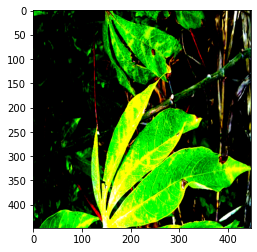

In [5]:
plt.imshow(val_ds.__getitem__(0).permute(2, 1, 0))

In [9]:
#Define prediction function

def prediction(model, files_path):
    labels = []
    model.eval()
    for img in val_ds:
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            label = torch.argmax(pred)
            labels.append(label.item())
    return np.array(labels)     

In [9]:
#Non-tta predictions

test_preds = prediction(model, database_base_path)
test_preds

array([1, 3, 4, ..., 1, 4, 2])

In [ ]:
#tta predictions

test_preds_tta = prediction(tta_model, files_path)
test_preds

In [7]:
#single prediction
sample = val_ds[0].unsqueeze(0).to(device)


In [10]:
tta_model(sample)

tensor([[ 0.3598,  3.4133, -1.1601, -1.4543, -1.0249]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [6]:
def validation(model, dataloader, dataset_size):
    running_corrects = 0
    since = time.time()
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    epoch_acc = running_corrects.double() / dataset_size

    print('acc:', epoch_acc.item())

    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [7]:
val_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label

database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')

df = df.sample(frac=1)

imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values

val_split = 0.1
batch_size = 1

dataset = Dataset(imgs[0:int(val_split*len(imgs))], labels, val_transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataset_sizes = len(dataset)

In [8]:
validation(tta_model, dataloader, dataset_sizes)

acc: 0.884525479195886

Training complete in 2m 9s


In [ ]:
acc: 0.8662926601215521 no tta
acc: 0.8625525946704068 tta.Rotate90(angles=[0, 180])
acc: 0.8714352501168771 tta.Scale(scales=[1, 2])